In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline


from fastai.learner import *

import torchtext
from torchtext import vocab, data
from torchtext.datasets import language_modeling

from fastai.rnn_reg import *
from fastai.rnn_train import *
from fastai.nlp import *
from fastai.lm_rnn import *

import pandas as pd

import dill as pickle

KeyError: 'pip._vendor.urllib3.contrib'

### TODO
- Use Pre Trained model to boost accuracy
- Hyper parameter tuning, especially drop out.
- Use early stopping
- Other arch? Ex: GRU (40% less params)
- Use custom embendding (https://www.kaggle.com/sbongo/do-pretrained-embeddings-give-you-the-extra-edge)
- OR try "Big" embenddings like Glove840B and FastText-English

## Language modeling

### Data

In this competition, you’re challenged to build a multi-headed model that’s capable of detecting different types of of toxicity like threats, obscenity, insults, and identity-based hate better than Perspective’s current models. You’ll be using a dataset of comments from Wikipedia’s talk page edits. Improvements to the current model will hopefully help online discussion become more productive and respectful.

You are provided with a large number of Wikipedia comments which have been labeled by human raters for toxic behavior. The types of toxicity are:

- toxic
- severe_toxic
- obscene
- threat
- insult
- identity_hate

You must create a model which predicts a probability of each type of toxicity for each comment.

File descriptions
- train.csv - the training set, contains comments with their binary labels
- test.csv - the test set, you must predict the toxicity probabilities for these comments. To deter hand labeling, the - test set contains some comments which are not included in scoring.
- sample_submission.csv - a sample submission file in the correct format


https://www.kaggle.com/c/jigsaw-toxic-comment-classification-challenge

In [2]:
PATH='data/comments/'

# TRN_PATH = 'train/all/'
# VAL_PATH = 'test/all/'
# TRN = f'{PATH}{TRN_PATH}'
# VAL = f'{PATH}{VAL_PATH}'

%ls {PATH}

dataset_test.csv   models/                    test.csv      train.csv
dataset_train.csv  sample_submission.csv      test.csv.zip  train.csv.zip
dataset_val.csv    sample_submission.csv.zip  tmp/


In [3]:
train_df = pd.read_csv(f'{PATH}dataset_train.csv')
val_df = pd.read_csv(f'{PATH}dataset_val.csv')
test_df = pd.read_csv(f'{PATH}dataset_test.csv')

In [4]:
display(train_df.head(),test_df.head(), val_df.head())

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,70990e503f69b2bc,I made those hiphop edits; my brother was on t...,0,0,0,0,0,0
1,7ba07580d1024706,""" """"definite form"""" I notice Factuarius wa...",0,0,0,0,0,0
2,115ba6c811a921ca,"No Apology? So, I don't even deserve an apol...",0,0,0,0,0,0
3,6f6394ef365a59b4,Add redlining information Perhaps if Redlinin...,0,0,0,0,0,0
4,03d445a7d3712459,""" Slight change to intro could the bit in ...",0,0,0,0,0,0


,id,comment_text
0,00001cee341fdb12,Yo bitch Ja Rule is more succesful then you'll...
1,0000247867823ef7,"== From RfC == The title is fine as it is, ..."
2,00013b17ad220c46,""" == Sources == * Zawe Ashton on Lapland..."
3,00017563c3f7919a,":If you have a look back at the source, the in..."
4,00017695ad8997eb,I don't anonymously edit articles at all.


,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,e3c68ab5b870f491,"It's okay, I am happy you did not delete it, t...",0,0,0,0,0,0
1,81d9caad4278a19e,""" Alright...you busted me, I tried to be nice...",0,0,0,0,0,0
2,51889ffaa71b7e4c,"Nthep, I get your point about the average read...",0,0,0,0,0,0
3,47279526ae03790f,""" But all the other pages have one... Big Na...",0,0,0,0,0,0
4,5a820f2b7f559d76,Air Florida Flight 90 I don't feel it belong...,0,0,0,0,0,0


In [4]:
train_df['comment_text'][3:10]

3    Add redlining information  Perhaps if Redlinin...
4    "   Slight change to intro   could the bit in ...
5    Under personal life...   I would add that Albe...
6    "- This is not ""creative"".  Those are the di...
7    "   Reviews to add   Pasting here for now http...
8    parentage.  According to user Rob the criteriu...
9    "  WHOOO HOOOOOOOO BIG FONT   OOOOOOOHHHHHHHH ...
Name: comment_text, dtype: object

In [5]:
test_df['comment_text'][0]

"Yo bitch Ja Rule is more succesful then you'll ever be whats up with you and hating you sad mofuckas...i should bitch slap ur pethedic white faces and get you to kiss my ass you guys sicken me. Ja rule is about pride in da music man. dont diss that shit on him. and nothin is wrong bein like tupac he was a brother too...fuckin white boys get things right next time.,"

In [6]:
list_classes = ["toxic", "severe_toxic", "obscene", "threat", "insult", "identity_hate"]
y = train_df[list_classes].values
list_sentences_train = train_df["comment_text"]
list_sentences_test = test_df["comment_text"]

In [7]:
list_sentences_train[0]

'I made those hiphop edits; my brother was on this computer earlier so he is probably the culprit; I will tell him to stop the vandalism. -'

In [9]:
# Chek for nulls in DF
train_df.isnull().any()

id               False
comment_text     False
toxic            False
severe_toxic     False
obscene          False
threat           False
insult           False
identity_hate    False
dtype: bool

In [10]:
test_df.isnull().any()

id              False
comment_text    False
dtype: bool

In [11]:
# COMMENT = "comment_text"
# train_df[COMMENT].filna("unknown", inplace=True)
# test_df[COMMENT].fillna("unknown", inplace=True)

In [12]:
# The distribution of the number of words in sentences.
lens_train = train_df.comment_text.str.len()
lens_train.mean(), lens_train.std(), lens_train.max()

(392.6388368832105, 585.78844116831601, 5000)

(array([    4.,   225.,  4337.,  4816.,  4559.,  4264.,  4009.,  3880.,  3710.,  3532.,  3479.,  3368.,  3196.,
         3019.,  3136.,  2929.,  2688.,  2705.,  2398.,  2354.,  2153.,  1993.,  1983.,  1941.,  1752.,  1741.,
         1674.,  1718.,  1590.,  1472.,  1443.,  1394.,  1387.,  1321.,  1225.,  1198.,  1132.,  1042.,  1002.,
          921.,   865.,   865.,   832.,   795.,   805.,   807.,   776.,   721.,   612.,   645.,   608.,   581.,
          605.,   600.,   558.,   542.,   498.,   500.,   462.,   502.,   440.,   404.,   459.,   414.,   445.,
          373.,   387.,   370.,   349.,   363.,   352.,   369.,   308.,   292.,   294.,   295.,   252.,   250.,
          239.,   261.,   241.,   265.,   243.,   239.,   231.,   243.,   208.,   232.,   210.,   232.,   213.,
          192.,   178.,   177.,   172.,   204.,   207.,   169.,   169.,   198.]),
 array([   0,   10,   20,   30,   40,   50,   60,   70,   80,   90,  100,  110,  120,  130,  140,  150,  160,
         170,  180,  190

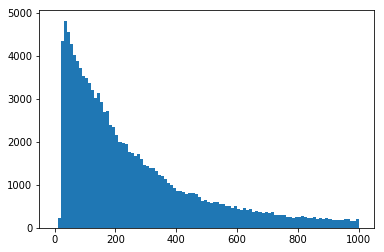

In [13]:
# Plot the histogram of sentenes' lenghs
plt.hist(lens_train, bins = np.arange(0, 1010, 10))

In [14]:
lens_test = test_df.comment_text.str.len()
lens_test.mean(), lens_test.std(), lens_test.max()

(364.87512078556318, 592.49209873027792, 5000)

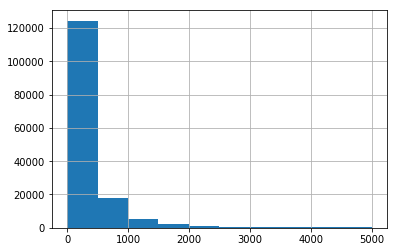

In [15]:
lens_test.hist()

In [16]:
len(train_df), len(test_df), len(val_df)

(127657, 153164, 31914)

Before we can analyze text, we must first *tokenize* it. This refers to the process of splitting a sentence into an array of words (or more generally, into an array of *tokens*).

In [17]:
# spacy_tok(train_df.comment_text[0])
' '.join(spacy_tok(train_df.comment_text[0]))

'I made those hiphop edits ; my brother was on this computer earlier so he is probably the culprit ; I will tell him to stop the vandalism . -'

We use Pytorch's [torchtext](https://github.com/pytorch/text) library to preprocess our data, telling it to use the wonderful [spacy](https://spacy.io/) library to handle tokenization.

First, we create a torchtext *field*, which describes how to preprocess a piece of text - in this case, we tell torchtext to make everything lowercase, and tokenize it with spacy.

In [18]:
TEXT = data.Field(sequential=True, lower=True, tokenize=spacy_tok)

fastai works closely with torchtext. We create a ModelData object for language modeling by taking advantage of `LanguageModelData`, passing it our torchtext field object, and the paths to our training, test, and validation sets. In this case, we don't have a separate test set, so we'll just use `VAL_PATH` for that too.

As well as the usual `bs` (batch size) parameter, we also not have `bptt`; this define how many words are processing at a time in each row of the mini-batch. More importantly, it defines how many 'layers' we will backprop through. Making this number higher will increase time and memory requirements, but will improve the model's ability to handle long sentences.

In [19]:
bs=64; bptt=70

In [20]:
# FILES = dict(train=TRN_PATH, validation=VAL_PATH, test=VAL_PATH)
# md = LanguageModelData.from_text_files(PATH, TEXT, **FILES, bs=bs, bptt=bptt, min_freq=10)

In [21]:
# Load our dfs, using test set for validation and test.
md = LanguageModelData.from_dataframes(PATH, 
                                       TEXT, 
                                       col= 'comment_text', 
                                       train_df=train_df, 
                                       val_df=val_df, 
                                       test_df=test_df,
                                       bs=bs, 
                                       bptt=bptt, 
                                       min_freq=10)

After building our `ModelData` object, it automatically fills the `TEXT` object with a very important attribute: `TEXT.vocab`. This is a *vocabulary*, which stores which words (or *tokens*) have been seen in the text, and how each word will be mapped to a unique integer id. We'll need to use this information again later, so we save it.

*(Technical note: python's standard `Pickle` library can't handle this correctly, so at the top of this notebook we used the `dill` library instead and imported it as `pickle`)*.

In [22]:
pickle.dump(TEXT, open(f'{PATH}models/TEXT.pkl','wb'))

Here are the: # batches; # unique tokens in the vocab; # tokens in the training set; # sentences

In [23]:
len(md.trn_dl), md.nt, len(md.trn_ds), len(md.trn_ds[0].text)

(2383, 23705, 1, 10680972)

This is the start of the mapping from integer IDs to unique tokens.

In [24]:
# 'itos': 'int-to-string'
TEXT.vocab.itos[:12]

['<unk>', '<pad>', '.', 'the', ',', '"', 'to', 'i', ' ', 'of', 'and', 'you']

Note that in a `LanguageModelData` object there is only one item in each dataset: all the words of the text joined together.

torchtext will handle turning this words into integer IDs for us automatically.

Our `LanguageModelData` object will create batches with 64 columns (that's our batch size), and varying sequence lengths of around 80 tokens (that's our `bptt` parameter - *backprop through time*).

Each batch also contains the exact same data as labels, but one word later in the text - since we're trying to always predict the next word. The labels are flattened into a 1d array.

### Train our embedding

We have a number of parameters to set - we'll learn more about these later, but you should find these values suitable for many problems.

In [25]:
em_sz = 200  # size of each embedding vector
nh = 500     # number of hidden activations per layer
nl = 3       # number of layers

Researchers have found that large amounts of *momentum* (which we'll learn about later) don't work well with these kinds of *RNN* models, so we create a version of the *Adam* optimizer with less momentum than it's default of `0.9`.

In [26]:
# TODO try Nadam
opt_fn = partial(optim.Adam, betas=(0.7, 0.99))

fastai uses a variant of the state of the art [AWD LSTM Language Model](https://arxiv.org/abs/1708.02182) developed by Stephen Merity. A key feature of this model is that it provides excellent regularization through [Dropout](https://en.wikipedia.org/wiki/Convolutional_neural_network#Dropout). There is no simple way known (yet!) to find the best values of the dropout parameters below - you just have to experiment...

However, the other parameters (`alpha`, `beta`, and `clip`) shouldn't generally need tuning.

In [27]:
learner = md.get_model(opt_fn, em_sz, nh, nl,
               dropouti=0.05, dropout=0.05, wdrop=0.1, dropoute=0.02, dropouth=0.05)
learner.reg_fn = partial(seq2seq_reg, alpha=2, beta=1)
learner.clip=0.3

As you can see below, I gradually tuned the language model in a few stages. I possibly could have trained it further (it wasn't yet overfitting), but I didn't have time to experiment more. Maybe you can see if you can train it to a better accuracy! (I used `lr_find` to find a good learning rate, but didn't save the output in this notebook. Feel free to try running it yourself now.)

HBox(children=(IntProgress(value=0, description='Epoch', max=1), HTML(value='')))

 85%|████████▍ | 2020/2383 [02:09<00:23, 15.60it/s, loss=20]  

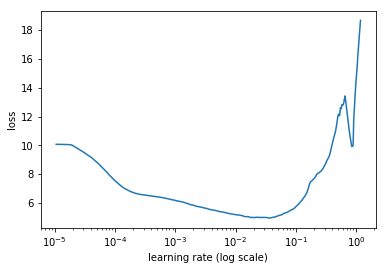

In [28]:
learner.lr_find()
learner.sched.plot()

In [29]:
learner.fit(3e-4, 4, wds=1e-6, cycle_len=1, cycle_mult=2)

HBox(children=(IntProgress(value=0, description='Epoch', max=15), HTML(value='')))

  0%|          | 4/2383 [00:00<03:16, 12.11it/s, loss=10.1]

Exception in thread Thread-4:
Traceback (most recent call last):
  File "/home/paperspace/anaconda3/envs/fastai/lib/python3.6/threading.py", line 916, in _bootstrap_inner
    self.run()
  File "/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/tqdm/_tqdm.py", line 148, in run
    for instance in self.tqdm_cls._instances:
  File "/home/paperspace/anaconda3/envs/fastai/lib/python3.6/_weakrefset.py", line 60, in __iter__
    for itemref in self.data:
RuntimeError: Set changed size during iteration



epoch      trn_loss   val_loss                                
    0      5.622705   5.524354  
    1      5.104502   4.996464                                
    2      5.000618   4.906469                                
    3      4.792215   4.691844                                
    4      4.646923   4.573264                                
    5      4.595919   4.523276                                
    6      4.596083   4.512991                                
    7      4.509743   4.442369                                
    8      4.429667   4.371382                                
    9      4.38678    4.324041                                
    10     4.342132   4.289117                                
    11     4.328785   4.266299                                
    12     4.301584   4.252805                                
    13     4.299927   4.247649                                
    14     4.297321   4.247074                                



[4.2470741]

In [30]:
learner.save_encoder('adam1_enc')

In [31]:
learner.load_encoder('adam1_enc')

In [32]:
learner.load_cycle('adam3_10',2)

FileNotFoundError: [Errno 2] No such file or directory: 'data/comments/models/adam3_10_cyc_2.h5'

In [ ]:
learner.fit(3e-3, 1, wds=1e-6, cycle_len=10)

In [ ]:
learner.save_encoder('adam3_10_enc')

In the sentiment analysis section, we'll just need half of the language model - the *encoder*, so we save that part.

In [ ]:
learner.save_encoder('adam3_20_enc')

In [ ]:
learner.load_encoder('adam3_20_enc')

Language modeling accuracy is generally measured using the metric *perplexity*, which is simply `exp()` of the loss function we used.

In [ ]:
math.exp(4.165)

In [ ]:
pickle.dump(TEXT, open(f'{PATH}models/TEXT.pkl','wb'))

### Test

In [ ]:
list_sentences_train[500]

We can play around with our language model a bit to check it seems to be working OK. First, let's create a short bit of text to 'prime' a set of predictions. We'll use our torchtext field to numericalize it so we can feed it to our language model.

In [ ]:
m=learner.model
ss="""We can see another"""
s = [spacy_tok(ss)]
t=TEXT.numericalize(s)
' '.join(s[0])

We haven't yet added methods to make it easy to test a language model, so we'll need to manually go through the steps.

In [ ]:
# Set batch size to 1
m[0].bs=1
# Turn off dropout
m.eval()
# Reset hidden state
m.reset()
# Get predictions from model
res,*_ = m(t)
# Put the batch size back to what it was
m[0].bs=bs

Let's see what the top 10 predictions were for the next word after our short text:

In [ ]:
nexts = torch.topk(res[-1], 10)[1]
[TEXT.vocab.itos[o] for o in to_np(nexts)]

...and let's see if our model can generate a bit more text all by itself!

In [ ]:
print(ss,"\n")
for i in range(50):
    n=res[-1].topk(2)[1]
    n = n[1] if n.data[0]==0 else n[0]
    print(TEXT.vocab.itos[n.data[0]], end=' ')
    res,*_ = m(n[0].unsqueeze(0))
print('...')

### Sentiment

We'll need to the saved vocab from the language model, since we need to ensure the same words map to the same IDs.

In [ ]:
LABELS = data.Field(sequential=False, use_vocab=False)
TEXT = pickle.load(open(f'{PATH}models/TEXT.pkl','rb'))

`sequential=False` tells torchtext that a text field should be tokenized (in this case, we just want to store the 'positive' or 'negative' single label).

`splits` is a torchtext method that creates train, test, and validation sets. The IMDB dataset is built into torchtext, so we can take advantage of that. Take a look at `lang_model-arxiv.ipynb` to see how to define your own fastai/torchtext datasets.

In [ ]:
%%time
tv_datafields = [("id", None), # we won't be needing the id, so we pass in None as the field
                 ("comment_text", TEXT), 
                 ("toxic", LABELS),
                 ("severe_toxic", LABELS), 
                 ("threat", LABELS),
                 ("obscene", LABELS), 
                 ("insult", LABELS),
                 ("identity_hate", LABELS)]

trn, vld = TabularDataset.splits(
        path=f'{PATH}', # the root directory where the data lies
        train='dataset_train.csv', validation="dataset_val.csv",
        format='csv',
        skip_header=True, # if your csv header has a header, make sure to pass this to ensure it doesn't get proceesed as data!
        fields=tv_datafields)

tst_datafields = [("id", None), # we won't be needing the id, so we pass in None as the field
                 ("comment_text", TEXT)
]

tst = TabularDataset(
        path=f'{PATH}dataset_test.csv', # the file path
        format='csv',
        skip_header=True, # if your csv header has a header, make sure to pass this to ensure it doesn't get proceesed as data!
        fields=tst_datafields)

In [ ]:
trn[0].__dict__.keys()

In [ ]:
' '.join(trn[0].comment_text[:16])

In [ ]:
trn.fields

In [ ]:
# Create splits tuple to use in fasta.ai
splits = (trn, vld)

fastai can create a ModelData object directly from torchtext splits.

In [ ]:
m2 = TextData.from_splits(PATH, splits, bs, text_name='comment_text', label_name='toxic')

In [ ]:
m3 = m2.get_model(opt_fn, 1500, bptt, emb_sz=em_sz, n_hid=nh, n_layers=nl, 
                   dropout=0.1, dropouti=0.4, wdrop=0.5, dropoute=0.05, dropouth=0.3)

m3.reg_fn = partial(seq2seq_reg, alpha=2, beta=1)
m3.load_encoder(f'adam3_20_enc')

Because we're fine-tuning a pretrained model, we'll use differential learning rates, and also increase the max gradient for clipping, to allow the SGDR to work better.

In [ ]:
m3.clip=25.
lrs=np.array([1e-4,1e-3,1e-2])

In [ ]:
m3.freeze_to(-1)
m3.fit(lrs/2, 1, metrics=[accuracy])
m3.unfreeze()
m3.fit(lrs, 1, metrics=[accuracy], cycle_len=1)

In [ ]:
m3.fit(lrs, 7, metrics=[accuracy], cycle_len=2, cycle_save_name='imdb2')

In [ ]:
m3.load_cycle('imdb2', 4)

In [ ]:
accuracy_np(*m3.predict_with_targs())

In [ ]:
m2 = TextData.from_splits(PATH, splits, bs, text_name='comment_text', label_name='severe_toxic')

m3 = m2.get_model(opt_fn, 1500, bptt, emb_sz=em_sz, n_hid=nh, n_layers=nl, 
                   dropout=0.1, dropouti=0.4, wdrop=0.5, dropoute=0.05, dropouth=0.3)

m3.reg_fn = partial(seq2seq_reg, alpha=2, beta=1)
m3.load_encoder(f'adam3_20_enc')

m3.clip=25.
lrs=np.array([1e-4,1e-3,1e-2])

m3.freeze_to(-1)
m3.fit(lrs/2, 1, metrics=[accuracy])
m3.unfreeze()
m3.fit(lrs, 1, metrics=[accuracy], cycle_len=1)
m3.fit(lrs, 7, metrics=[accuracy], cycle_len=2, cycle_save_name='severe_toxic2')

m3.load_cycle('severe_toxic2', 4)
accuracy_np(*m3.predict_with_targs())

A recent paper from Bradbury et al, [Learned in translation: contextualized word vectors](https://einstein.ai/research/learned-in-translation-contextualized-word-vectors), has a handy summary of the latest academic research in solving this IMDB sentiment analysis problem. Many of the latest algorithms shown are tuned for this specific problem.

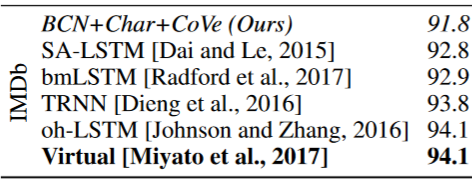

As you see, we just got a new state of the art result in sentiment analysis, decreasing the error from 5.9% to 5.5%! You should be able to get similarly world-class results on other NLP classification problems using the same basic steps.

There are many opportunities to further improve this, although we won't be able to get to them until part 2 of this course...

### End